# Info
The goal of this project consists of designing a model to generate audio features using Deep autoencoders. In order to do so, the [Mozilla Common Voice dataset](https://voice.mozilla.org/en) is used for training, since it has several recorded files whose quality is validated by users. We don't pay attention to any of the available labels, since performing speech recognition using weak labels is out of the scope of this work.

* First approach: replicate the implementation and training of [Audeep](https://arxiv.org/abs/1712.04382).
* Future approaches: implement new models.

## References
* https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
* https://stackoverflow.com/questions/51749404/how-to-connect-lstm-layers-in-keras-repeatvector-or-return-sequence-true
* https://machinelearningmastery.com/lstm-autoencoders/
* https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
path = '.'
feature_path = 'features';
TAG = 'MOZILLA_EN'
from numpy import array
from librosa.feature import  melspectrogram
from librosa.display import specshow
from sklearn.model_selection import train_test_split
import os, random,datetime, librosa, tarfile, sys, io, h5py, time, csv
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt

# Feature scaling
The cells below show how features scaled considering z-score. Both average and standard deviation are computed using Welford's algorithm, since for a real signal that is continuously sampled along time we don't expect to have a global value for these two parameters.

In [2]:
from libraries.welford import Welford
def ScaleData(S_matrix, verbose = False):
    '''
    Function designed to scale a spectrogram-like signal considering each frequency bin
    independently. The scaling is the z-score, and mean and average are computed using
    the Welford's algorithm.
    
    The code from Welford's is the one designed by: 
    https://gist.github.com/alexalemi/2151722
    '''
    ave = np.zeros(S_matrix.shape)
    stdev =np.zeros(S_matrix.shape)
    for f in range(S_matrix.shape[0]):
        '''
        We compute the moving average and std for each frequency bin. The idea is that this
        procedure should be performed with signals in real scenarios for normalization 
        purposes, and consequently we performe those independently for each of the files,
        both from train and test.
        '''
        runner = Welford();
        for t in range(S_matrix.shape[1]):
            runner(S_matrix[f,t])
            ave[f,t] = runner.mean;
            stdev[f,t] = runner.std;
            if t == 0:
                ave[f,t] = runner.mean;
                stdev[f,t] = 1;
        del runner

    if verbose == True:
        plt.figure(figsize=(15,10))
        plt.subplot(221)
        plt.imshow(S_matrix)
        plt.colorbar()
        plt.title('Original')
        plt.subplot(222)
        plt.imshow((S_matrix-ave)/stdev)
        plt.colorbar()
        plt.title('Scaled')
        plt.subplot(223)
        plt.imshow(ave)
        plt.colorbar()
        plt.title('Moving average (f)')
        plt.subplot(224)
        plt.imshow(stdev)
        plt.colorbar()
        plt.title('Moving std (f)')
    return (S_matrix-ave+1e-30)/(stdev+1e-30);




maxInt = sys.maxsize

while True:
    # This line is used to avoid overflow size in the system.
    # https://stackoverflow.com/questions/15063936/csv-error-field-larger-than-field-limit-131072
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
        
def get_MOZILLA_files(datapath, dataset_name):
    filelist = [];
    with open(os.path.join(datapath,dataset_name)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            filelist.append(os.path.join('clips',row[0].split('\t')[1]))
    return filelist[1:]



## Feature computation and storage
In total, `64` log-Mel energy bands are extracted considering a temporal window of `20ms` for the Fast Fourier Transform, and an overlapping factor of `50%`. From the `MOZILLA_EN` subset we select `200k` audio elements, but take into consideration that there should be more available if the need for them arises.

For each audio file, both log-Mel energy bands and Power are stored into a dataset element of a hdf5 file.

In [3]:
files_to_download = 200000;

win = 20;
win_length = win*1e-3; # Standard: 100ms.
hop_length = win_length*.5; # 50% overlapping
fs = 48000;
datapath = os.path.join('data','MOZILLA_EN')
h5_path = os.path.join(feature_path,'Features_{}_win{}.h5'.format(TAG,win));
    
write_features = False;

counter = 0;
n_mel = 64;
start = time.time();
ommited_list = []
if write_features == True:
    tar = tarfile.open(os.path.join(datapath,"en.tar.gz"),'r:gz')
    hf = h5py.File(h5_path,'w');
    
    for member in tar:
        filename = member.name;
        if len(filename.split('/')) ==2:
            member = tar.getmember(filename)
            f=tar.extractfile(member)
            content=f.read()
            try:
                song = AudioSegment.from_file(io.BytesIO(content), format="mp3")
            except:
                print('Mistake with file: {}'.format(filename))
                continue
                
            data = song.get_array_of_samples()
            if np.std(data) != 0:                
                data_aux = array(data)/np.max(np.abs(data));

                data_aux = librosa.effects.preemphasis(data_aux)
                S = melspectrogram(data_aux, sr = fs, 
                                   n_fft = int(2**np.ceil(np.log2(abs(win_length*fs)))), 
                                   n_mels = n_mel,
                                   hop_length = int(hop_length*fs),
                                   win_length = int(win_length*fs),
                                   htk=True
                                  )

                power = np.mean(S, axis =0);
                S = librosa.power_to_db(S);            
                S = ScaleData(S)
                hf.create_dataset(filename+'-spec', data=S);
                hf.create_dataset(filename+'-pow', data=power);
                counter+=1;

                if counter%100 == 0:
                    end = time.time();
                    print('Files prºocessed: {0}. Elapsed T(s): {1}. T per file(s): {2}'.format(counter, (end-start), (end-start)/counter))
                if counter == files_to_download:
                    hf.close()
                    break
            else:
                print('Ommited: {}'.format(filename))
                ommited_list.append(filename)
            
        

The following cell of code is useful if you are willing to use the MOZILLA Spanish subset, although it has a significantly smaller number of samples.

In [4]:
win = 20;
win_length = win*1e-3; # Standard: 100ms.
hop_length = win_length*.5; # 50% overlapping

    
if TAG == 'MOZILLA':
    datapath = os.path.join('data','MOZILLA')
    h5_path = os.path.join(feature_path,'Features_{}_win{}.h5'.format(TAG,win));
    X = get_MOZILLA_files(datapath, 'validated.tsv')    
    
elif TAG == 'MOZILLA_EN':
    hf = h5py.File(h5_path,'r');
    lines = []
    for x_ind in hf['clips'].keys():
        lines.append(os.path.join('clips',x_ind.replace('-spec','').replace('-pow','')))
    lines = list(set(lines))
        
write_features = False;

counter = 0;
n_mel = 64;
start = time.time();
if write_features == True:
    hf = h5py.File(h5_path,'w');
    
    for filename in X:
        if TAG == 'MOZILLA':
            data_aux, fs = librosa.load(os.path.join(datapath, filename))
        else:
            data_aux, fs = librosa.load(os.path.join(datapath, filename.replace('_0000_','_0_')+'.flac'))
        
        data_aux = librosa.effects.preemphasis(data_aux)
        S = melspectrogram(data_aux, sr = fs, 
                           n_fft = int(2**np.ceil(np.log2(abs(win_length*fs)))), 
                           n_mels = n_mel,
                           hop_length = int(hop_length*fs),
                           win_length = int(win_length*fs),
                           htk=True
                          )
        
        power = np.mean(S, axis =0);
        S = librosa.power_to_db(S);
        # We cut the last second of audio in order to have the same size in every Mel spectrogram
        S = S[:,:int(fs*9/(hop_length*fs)+1)];
        power = power[:int(fs*9/(hop_length*fs)+1)]
        S = ScaleData(S)
        hf.create_dataset(filename+'-spec', data=S);
        hf.create_dataset(filename+'-pow', data=power);
        counter+=1;
        
        if counter%100 == 0:
            end = time.time();
            print('Files prºocessed: {0}. Elapsed T(s): {1}. T per file(s): {2}'.format(counter, (end-start), (end-start)/counter))
            
    hf.close()
    


This is an *a posteriori* proposal, since I realized that some of the files actually had an anomalously long duration. As a consequence, some of the longest files are not considered for this training procedure. These files represent the `14.26%` of our `200k` elements subset.

In [5]:
# We remove files with a excesively long duration.
hf = h5py.File(h5_path, 'r')
exception_data = [];

if TAG == 'MOZILLA_EN':
    exception_data = []
    counter = 0
    for i in hf['clips'].keys():
        if (i.split('-')[1] == 'spec'):
            if (hf['clips'][i].shape[1] > 10/win_length):
                exception_data.append(os.path.join('clips',i.replace('-spec','')))
        
print('Removed {}% out of {} files.'.format(len(exception_data)/len(hf['clips'].keys())*100,len(hf['clips'].keys())))



perc_test = .05;
X = [i for i in lines if (i in exception_data) == False]

X_train_split, X_test_split = train_test_split(X, 
                               test_size = perc_test, 
                               random_state = 1492, 
                               shuffle = True,
                               );
y_train_split = X_train_split;

Removed 14.2645% out of 200000 files.


# Feeding the model using a generator

We train using a generator that reads the features that were extracted in the previous sections. Two considerations need to be appointed:
* The model to be tested is an autoencoder, which means that the input and the output are the delayed versions of the same data. In this particular case, the delay is of one spectro-temporal unit.
* The inner neural network is a GRU unit, which means that it is specially designed to work with sequence data. As a consequence, the batches to be fed into the model need to have the same temporal duration. 

These two aspects need to be considered by our generator. We control the duration of each audio file using the `seq_length` parameter. Moreover, because of the structure of the first model of this work the generator will provide two different inputs: a delayed and a non-delayed version of the output data.

In [6]:
def generator_seq(h5_file, x_list, batch_size,seed_counter = 1000, seq_length = 100):    
    while True:
        random.seed(seed_counter)
        x_list_rand = random.sample(x_list,len(x_list));
        for i in np.arange(0,len(x_list_rand),batch_size):
            x_aux = [np.expand_dims(h5_file[x_list_rand[j]+'-spec'],axis=2) for j in np.arange(i, np.min([i+batch_size, len(x_list_rand)]))]
            x_vec = [];
            x_vec_pre = [];
            for ind in range(len(x_aux)):
                aux = x_aux[ind][:,-seq_length-1:,:];
                if (aux.shape[1] == seq_length+1):
                    x_vec.append(aux[:,1:,:]);
                    x_vec_pre.append(aux[:,:-1,:]);

            x_aux = np.concatenate(x_vec, axis=2)
            x_aux_pre = np.concatenate(x_vec_pre, axis=2)
            
            x = np.transpose(x_aux, [2,1,0])
            x = x/(np.max(np.abs(x))+1e-30);
            x_pre = np.transpose(x_aux_pre, [2,1,0])
            x_pre = x_pre/(np.max(np.abs(x_pre))+1e-30);
            y = x;      
            
            
            try:
                yield ({'in_signal':x,'in_pre':x_pre},{'out_main':y})

            except StopIteration:
                return  
        seed_counter+=100;
            
            

# generate_arrays_from_file(hf, X_train_split, y_train_split)
# x_batch, y_batch = generate_arrays_autoencoder(hf, X_train_split, 5)

# Model structure and training
The following image depicts the proposed model, which is an approach to AuDeep. Notice that data the output is common, whereas there are two different inputs. Their differences are insignificant: one is a delayed version of the other.

With respect to the output, notice that is a Dense Neural Network that is applied along the temporal axis using a TimeDistributed approach, so it means that the same DNN is used for every temporal frame.

Using TensorFlow backend.
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

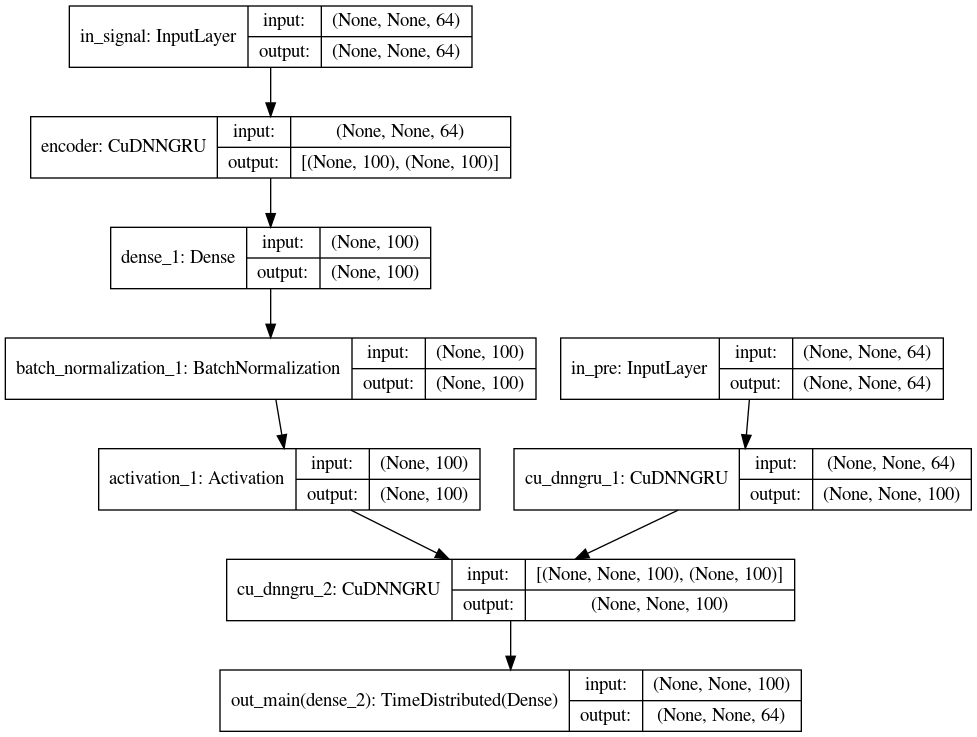

In [7]:
from keras.utils import plot_model
from Mozilla_models import import_models
from IPython.display import Image

hf = h5py.File(h5_path, 'r')
model_name = 'GRU_autoencoder';
# plot_model(import_models(model_name,100, 1492, 64),show_shapes=True, show_layer_names=True, to_file='{}.png'.format(model_name))
Image(retina=True, filename='{}.png'.format(model_name))

The following cell shows how training is performed. Since this is a **regression task**, the selected loss is the Mean Absolute Error. The selected optimizer is Adam, and some of the parameters that we can control are the following:
* n_units: It determines how many units the GRU will have.
* seq_legnth: It determines the temporal duration of the audio sequences that are fed by the generator.

Both the batch size and the number of epochs should be adjusted, as well.


In [8]:
random_seed = 1492;
n_units = 100;
seq_length = 200;
n_epochs = 50;
epoch_init = 0;
batch_size = 256;
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
    
def time_decay(epoch, lr):
    if epoch == 5000: # Fixed
        return lr/2;
    elif epoch == 10000:
        return lr/2;
    else:
        return lr    
    
for ind_mod in [1]:#np.arange(1,5):
    if ind_mod == 1:
        model_name = 'GRU_autoencoder';
        
    
    if epoch_init == 0:
        model = import_models(model_name, n_units, random_seed, n_mel)    
        lr = .01
        optimizer = Adam(lr = lr,  
                         clipnorm=1
                        ) 
        if model_name == 'onset':
            losses = {'out_main':'mae',
                      'out_onset':'binary_crossentropy'}
            loss_weights = {'out_main':10.0,
                            'out_onset':.1}
      
            model.compile(loss=losses, loss_weights = loss_weights, optimizer=optimizer)
        else:
            losses = 'mae'
            model.compile(loss=losses, optimizer=optimizer)
        tb_base = model_name+'-'+str(datetime.datetime.now()).replace(' ','_').replace(':','.');
        os.mkdir(os.path.join('logs',tb_base))


       
    else:
        from keras.models import load_model 
        model = load_model(os.path.join('./logs',tb_base,'ChkPoint_{}.h5'.format(model_name)))
        
    checkpoint = ModelCheckpoint(os.path.join('./logs',tb_base,'ChkPoint_{}.h5'.format(model_name)), monitor='loss', verbose=1, save_best_only=True, mode='min')    
    
    lrate = LearningRateScheduler(time_decay,verbose=1)
    

    h = model.fit_generator(generator_seq(hf, X_train_split,batch_size, seq_length),
                            steps_per_epoch = len(X_train_split)/batch_size,
                            epochs = n_epochs,
                            validation_data = generator_seq(hf, X_test_split,batch_size, seq_length),
                            validation_steps = len(X_test_split)/batch_size,
                            callbacks=[TensorBoard(log_dir=os.path.join('./logs',tb_base)),
    #                                    checkpoint,
                                       lrate],
                            initial_epoch = epoch_init
                           )
    model.save(os.path.join('logs',tb_base,model_name+'.h5'))



    metadata = [{'model_name': model_name,
                'n_epochs': n_epochs,
                'batch_size': batch_size,
                'optimizer': optimizer,
                'opt_lr': lr,
                'n_mel': n_mel,
                'n_units': n_units,
                'seq_length': seq_length}]

    csv_file = os.path.join('logs',tb_base,'metadata.csv')
    
    with open(csv_file, 'w') as csvdoc:    
        writer = csv.DictWriter(csvdoc, fieldnames=metadata[0].keys())
        writer.writeheader()
        for i in metadata:
            print(i)
            writer.writerow(i)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
266/265 [==============================] - 1240s 5s/step - loss: 0.0251 - val_loss: 0.0221
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
266/265 [==============================] - 1261s 5s/step - loss: 0.0222 - val_loss: 0.0216
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
266/265 [==============================] - 1257s 5s/step - loss: 0.0221 - val_loss: 0.0209
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
266/265 [==============================] - 1252s 5s/step - loss: 0.0212 - val_loss: 0.0219
Epoch 5/200

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
266/265 [===========================

KeyboardInterrupt: 

In [13]:
# for i in model.get_weights():
#     print(i.shape,i)
# model.get_layer('out_onset').get_weights()


In [ ]:
test_batches = Batch(1, X_test_split, X_test_split, range(len(X_test_split)), h5_path);
x_batch, y_batch = test_batches.get_batch_n_data( 200)
y_pred = model.predict(x_batch);
feature_extractor = Model(inputs = model.layers[0].input, 
                          outputs = model.get_layer('encoder').output)
y_feature = feature_extractor.predict(x_batch)


plt.figure(figsize=(15,5))
plt.subplot(311);
plt.title('Original spectrogram')
specshow(np.squeeze(np.transpose(x_batch,[0,2,1])), y_axis='mel')
plt.colorbar()
plt.subplot(312)
plt.title('Reconstructed spectrogram')
specshow(np.squeeze(np.transpose(y_pred,[0,2,1])), y_axis='mel')
plt.colorbar()
# plt.subplot(313)
# plt.title('Encoded features')
# plt.plot(np.squeeze(np.transpose(y_feature,[0,2,1]))[0])
# plt.colorbar()